# Twitter sentiment analysis

## Import libraries

In [45]:
import pandas as pd
import re
import nltk
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem.porter import PorterStemmer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [46]:
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /Users/lilian/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/lilian/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

## Preprocessing

Dataset source : https://www.kaggle.com/datasets/kazanova/sentiment140

In [47]:
df = pd.read_csv('tweet_dataset.csv', encoding='ISO-8859-1', )

In [48]:
df.shape

(1599999, 6)

In [49]:
df.head()

,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, that's a bummer. You shoulda got David Carr of Third Day to do it. ;D"
0,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
1,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
2,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
3,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."
4,0,1467811372,Mon Apr 06 22:20:00 PDT 2009,NO_QUERY,joy_wolf,@Kwesidei not the whole crew


In [50]:
df.columns = ['target', 'id', 'date', 'flag', 'user', 'text']
df.head()

,target,id,date,flag,user,text
0,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
1,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
2,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
3,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."
4,0,1467811372,Mon Apr 06 22:20:00 PDT 2009,NO_QUERY,joy_wolf,@Kwesidei not the whole crew


In [51]:
df.drop(['id', 'date', 'flag', 'user'], axis=1, inplace=True)
df.head()

,target,text
0,0,is upset that he can't update his Facebook by ...
1,0,@Kenichan I dived many times for the ball. Man...
2,0,my whole body feels itchy and like its on fire
3,0,"@nationwideclass no, it's not behaving at all...."
4,0,@Kwesidei not the whole crew


In [52]:
df.isnull().sum(axis = 0)

target    0
text      0
dtype: int64

In [53]:
df['target'].value_counts()

target
4    800000
0    799999
Name: count, dtype: int64

In [54]:
df['target'] = df['target'].replace(4, 1)

In [55]:
df['target'].value_counts()

target
1    800000
0    799999
Name: count, dtype: int64

<Axes: ylabel='target'>

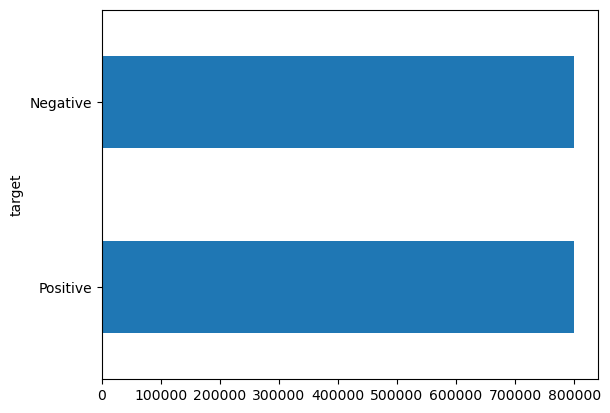

In [56]:
df['target'].replace({0: "Negative", 1: "Positive"}).value_counts().plot(kind='barh')

In [57]:
def decontracted(text):
    decontracted = re.sub(r"won't", "will not", text)
    decontracted = re.sub(r"can\'t", "can not", decontracted)
    decontracted = re.sub(r"n\'t", " not", decontracted)
    decontracted = re.sub(r"\'re", " are", decontracted)
    decontracted = re.sub(r"\'s", " is", decontracted)
    decontracted = re.sub(r"\'d", " would", decontracted)
    decontracted = re.sub(r"\'ll", " will", decontracted)
    decontracted = re.sub(r"\'t", " not", decontracted)
    decontracted = re.sub(r"\'ve", " have", decontracted)
    decontracted = re.sub(r"\'m", " am", decontracted)
    
    return decontracted

In [58]:
df['decontracted_text'] = df['text'].apply(decontracted)

In [59]:
def clean(text): 
    cleaned = re.sub(r'http\S+', '', text)
    cleaned = re.sub(r'@\w+', '', cleaned)
    cleaned = re.sub(r'#\w+', '', cleaned)
    cleaned = re.sub(r'[^A-Za-z\s]', '', cleaned)
    cleaned = cleaned.lower()
    cleaned = cleaned.strip()
    
    return cleaned

In [60]:
df['cleaned_text'] = df['decontracted_text'].apply(clean)

In [61]:
positive_df = df[df['target'] == 1]
negative_df = df[df['target'] == 0]

In [62]:
positive_df.head()

,target,text,decontracted_text,cleaned_text
799999,1,I LOVE @Health4UandPets u guys r the best!!,I LOVE @Health4UandPets u guys r the best!!,i love u guys r the best
800000,1,im meeting up with one of my besties tonight! ...,im meeting up with one of my besties tonight! ...,im meeting up with one of my besties tonight c...
800001,1,"@DaRealSunisaKim Thanks for the Twitter add, S...","@DaRealSunisaKim Thanks for the Twitter add, S...",thanks for the twitter add sunisa i got to mee...
800002,1,Being sick can be really cheap when it hurts t...,Being sick can be really cheap when it hurts t...,being sick can be really cheap when it hurts t...
800003,1,@LovesBrooklyn2 he has that effect on everyone,@LovesBrooklyn2 he has that effect on everyone,he has that effect on everyone


In [63]:
negative_df.head()

,target,text,decontracted_text,cleaned_text
0,0,is upset that he can't update his Facebook by ...,is upset that he can not update his Facebook b...,is upset that he can not update his facebook b...
1,0,@Kenichan I dived many times for the ball. Man...,@Kenichan I dived many times for the ball. Man...,i dived many times for the ball managed to sav...
2,0,my whole body feels itchy and like its on fire,my whole body feels itchy and like its on fire,my whole body feels itchy and like its on fire
3,0,"@nationwideclass no, it's not behaving at all....","@nationwideclass no, it is not behaving at all...",no it is not behaving at all i am mad why am i...
4,0,@Kwesidei not the whole crew,@Kwesidei not the whole crew,not the whole crew


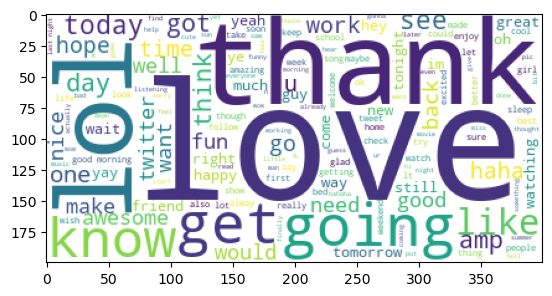

In [64]:
stop_words = set(stopwords.words('english'))

wordcloud = WordCloud(stopwords = stop_words, background_color = 'white')
wordcloud.generate(' '.join(positive_df['cleaned_text']))

plt.imshow(wordcloud)
plt.show()

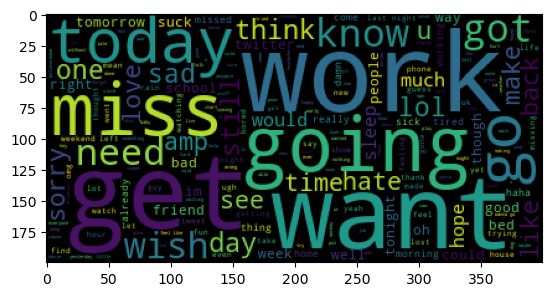

In [65]:
wordcloud = WordCloud(stopwords = stop_words, background_color = 'black')
wordcloud.generate(' '.join(negative_df['cleaned_text']))

plt.imshow(wordcloud)
plt.show()

In [66]:
porter_stemmer = PorterStemmer()

In [67]:
def stemming(text):
    tokens = word_tokenize(text)
    tokens = [porter_stemmer.stem(word) for word in tokens if word not in stop_words]
    stemmed = ' '.join(tokens)

    return stemmed

In [68]:
df['stemmed_text'] = df['cleaned_text'].apply(stemming)

In [69]:
df['stemmed_text'].head()

0    upset updat facebook text might cri result sch...
1         dive mani time ball manag save rest go bound
2                      whole bodi feel itchi like fire
3                                        behav mad see
4                                           whole crew
Name: stemmed_text, dtype: object

In [70]:
X = df['stemmed_text'].values
y = df['target'].values

In [71]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [72]:
X_train.shape

(1279999,)

In [73]:
X_test.shape

(320000,)

In [74]:
vectorizer = TfidfVectorizer()

X_train = vectorizer.fit_transform(X_train)
X_test = vectorizer.transform(X_test)

In [86]:
X_test[0].shape

(1, 305955)

## Logistic Regression

In [76]:
model = LogisticRegression(max_iter=1000)

In [77]:
model.fit(X_train, y_train)

LogisticRegression(max_iter=1000)

## Model evaluation

In [78]:
y_pred = model.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy Score: {accuracy:.2f}')

Accuracy Score: 0.77


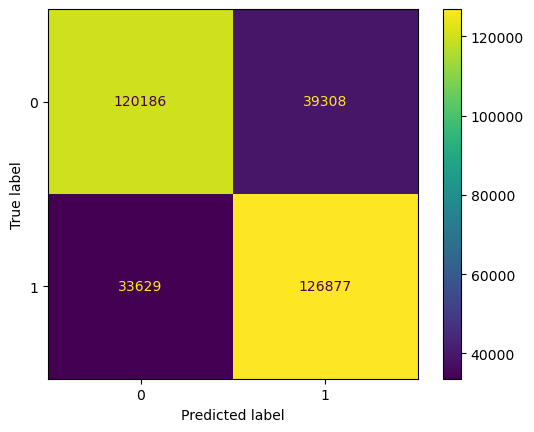

In [79]:
cm = confusion_matrix(y_test, y_pred)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1])
disp.plot()

plt.show()

Interpreting the confusion matrix: 
- True Negative (Top-Left Quadrant): Number of tweets that are actually negative and that have been predicted as negative.
- False Positive (Top-Right Quadrant): Number of tweets that are actually negative but have been predicted as positive.
- False Negative (Bottom-Left Quadrant): Number of tweets that are actually positive but have been predicted as negative.
- True Positive (Bottom-Right Quadrant): Number of tweets which are actually positive and which have been predicted as positive.

## Prediction

In [80]:
new_tweet = 'I hate Python developers!'

new_tweet_decontracted = decontracted(new_tweet)
new_tweet_cleaned = clean(new_tweet_decontracted)
new_tweet_stemmed = stemming(new_tweet_cleaned)
new_tweet_vectorized = vectorizer.transform([new_tweet_stemmed])

y_pred_new_tweet = model.predict(new_tweet_vectorized)
print(f'This tweet is {"positive" if y_pred_new_tweet[0] == 1 else "negative"}!')

This tweet is negative!
